<a href="https://colab.research.google.com/github/wqw547243068/school-of-ai-beijing/blob/master/code/lecture_3/lesson3_nural_network_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI-神经网络
![soai](https://github.com/wqw547243068/school-of-ai-beijing/raw/master/other/SoAI_logo_full.png)
- 【2019-05-19】王奇文，wqw547243068@163.com，[School of AI-Beijing](https://wqw547243068.github.io/school-of-ai-beijing/)


## 第五课-神经网络

- 神经网络基本原理

## 环境准备
- 详见第一课
- 注意：要开启GPU，否则cuda找不到，报错

In [0]:
%matplotlib inline
from fastai.basics import *

In [4]:
nn.modules

<module 'torch.nn.modules' from '/usr/local/lib/python3.6/dist-packages/torch/nn/modules/__init__.py'>

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

### 下载特定格式的数据
- 单独从以上网址下载数据到云端，并复制到指定位置

In [8]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-05-19 06:39:49--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  7.58MB/s    in 2.0s    

2019-05-19 06:39:56 (7.58 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



- 先检查自己的云环境，数据目录，是否有/root/.fastai/data

In [23]:
!ls -l /root/.fastai/data

ls: cannot access '/root/.fastai/data': No such file or directory


In [24]:
%%bash
# 创建目录并将数据copy过去
data_dir='/root/.fastai/data/mnist'
mkdir -p $data_dir
[ -f $data_dir ]|| mkdir -p $data_dir
pwd&&ls
cp mnist.pkl.gz $data_dir
ls $data_dir

/content
mnist.pkl.gz
sample_data
mnist.pkl.gz


In [0]:
path = Config().data_path()/'mnist'
#path = untar_data(URLs.MNIST_SAMPLE) # 不能用fastai内置的mnist数据集

In [29]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [0]:
# 读取pkl格式的数据文件
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

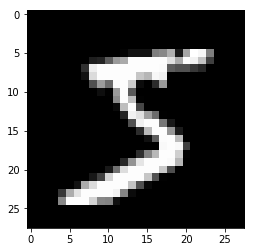

In [31]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [32]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [45]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [42]:
#from fastai.basics import *

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)
model = Mnist_Logistic().cuda()
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [41]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [43]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [46]:
model(x).shape

torch.Size([64, 10])

In [48]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

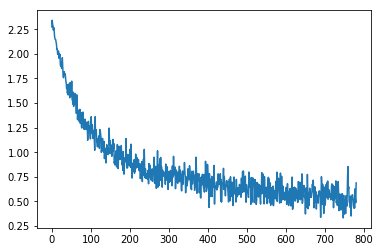

In [52]:
plt.plot(losses);

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

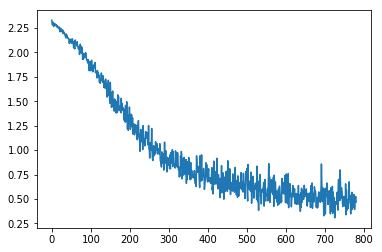

In [56]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

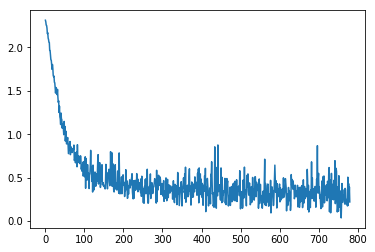

In [60]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

### 启动pdb调试器

In [62]:
%debug

> <ipython-input-44-e11ba1637688>(1)<module>()
----> 1 model(x).shape

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


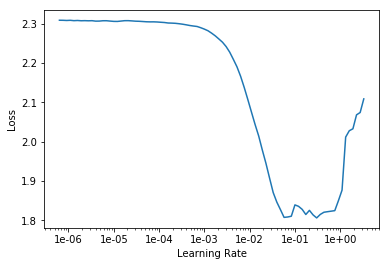

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.143112,0.129094,0.963000,00:03


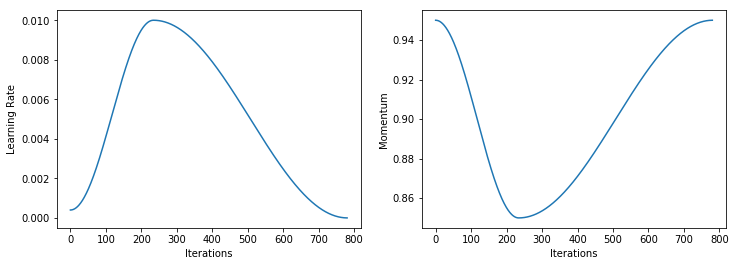

In [66]:
learn.recorder.plot_lr(show_moms=True)

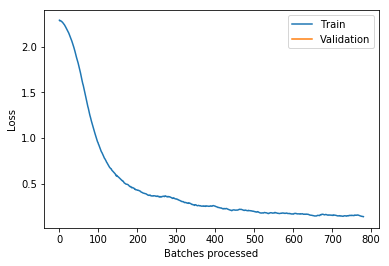

In [67]:
learn.recorder.plot_losses()

## Python实现神经网络
- 用纯python实现前馈神经网络，解决经典的异或问题
- 参考资料：[neural networks and deep learning](http://neuralnetworksanddeeplearning.com/chap1.html)，[中文版](https://github.com/wqw547243068/school-of-ai-beijing/blob/master/resource/%E7%A5%9E%E7%BB%8F%E2%BD%B9%E7%BB%9C%E5%92%8C%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0.pdf)
   - 第一章：使用神经网络识别手写数字
   - 第二章：反向传播算法如何工作
   - 第三章：改进神经网络的学习方法
   - 第四章：神经网络可以计算任何函数的可视化证明
   - 第五章：深度神经网络为何很难训练
   - 第六章：深度学习
- ![](https://pic1.zhimg.com/80/v2-e7688c681195f6197282dc4919b706d4_hd.jpg)

In [11]:
# coding:utf8
# How to build your own Neural Network from scratch in Python
# https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

import numpy as np

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],4) 
        self.weights2   = np.random.rand(4,1)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2


if __name__ == "__main__":
    X = np.array([[0,0,1],
                  [0,1,1],
                  [1,0,1],
                  [1,1,1]])
    y = np.array([[0],[1],[1],[0]])
    nn = NeuralNetwork(X,y)

    for i in range(1500):
        nn.feedforward()
        nn.backprop()

    print(nn.output)

[[0.022621]
 [0.984735]
 [0.975481]
 [0.020992]]


### mnist的pytorch实现
- [代码-kaggle](https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network)

In [0]:
# 请自行实现

### pytorch实现LR
- 代码

In [16]:
import torch 
from torch.autograd import Variable 

x_data = Variable(torch.Tensor([[1.0], [2.0], [3.0]])) 
y_data = Variable(torch.Tensor([[2.0], [4.0], [6.0]])) 


class LinearRegressionModel(torch.nn.Module): 

	def __init__(self): 
		super(LinearRegressionModel, self).__init__() 
		self.linear = torch.nn.Linear(1, 1) # One in and one out 

	def forward(self, x): 
		y_pred = self.linear(x) 
		return y_pred 

# our model 
our_model = LinearRegressionModel() 

criterion = torch.nn.MSELoss(size_average = False) 
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01) 

for epoch in range(500): 

	# Forward pass: Compute predicted y by passing 
	# x to the model 
	pred_y = our_model(x_data) 

	# Compute and print loss 
	loss = criterion(pred_y, y_data) 

	# Zero gradients, perform a backward pass, 
	# and update the weights. 
	optimizer.zero_grad() 
	loss.backward() 
	optimizer.step() 
	if epoch %10 == 0:
	    print('epoch {}, loss {}'.format(epoch, loss.data)) 

new_var = Variable(torch.Tensor([[4.0]])) 
pred_y = our_model(new_var) 
print("predict (after training)", 4, our_model(new_var).data[0][0]) 


epoch 0, loss 71.31343841552734
epoch 10, loss 0.4252530634403229
epoch 20, loss 0.3492105305194855
epoch 30, loss 0.30214229226112366
epoch 40, loss 0.2614228129386902
epoch 50, loss 0.22619125247001648
epoch 60, loss 0.1957077533006668
epoch 70, loss 0.16933244466781616
epoch 80, loss 0.1465115249156952
epoch 90, loss 0.12676668167114258
epoch 100, loss 0.10968242585659027
epoch 110, loss 0.09490067511796951
epoch 120, loss 0.08211089670658112
epoch 130, loss 0.07104498893022537
epoch 140, loss 0.06147032603621483
epoch 150, loss 0.05318605899810791
epoch 160, loss 0.046018172055482864
epoch 170, loss 0.039816342294216156
epoch 180, loss 0.034450460225343704
epoch 190, loss 0.029807545244693756
epoch 200, loss 0.025790374726057053
epoch 210, loss 0.022314677014946938
epoch 220, loss 0.01930735632777214
epoch 230, loss 0.016705285757780075
epoch 240, loss 0.014453970827162266
epoch 250, loss 0.012506077066063881
epoch 260, loss 0.010820627212524414
epoch 270, loss 0.009362328797578812

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## 附录

[![soai](https://github.com/wqw547243068/school-of-ai-beijing/raw/master/other/first_lecture.jpg)](https://wqw547243068.github.io/school-of-ai-beijing/)